In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core import display as ICD
import seaborn as sns
import glob
import scipy
import os
pd.set_option('display.max_columns', 100)
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [9]:
# import scikit learn packages

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

In [3]:
DATA_FOLDER = './avg_data/'
os.listdir(DATA_FOLDER)
all_anem=glob.glob(DATA_FOLDER + "anem*")
mast_anem=all_anem[:6]
top_anem=all_anem[6]
only_mag=True
h=np.arange(1.5,22,4)
df_list=[]
for idx,i in enumerate(mast_anem):
    df_temp=pd.read_csv(i, sep=" ", header=None, index_col=0, names=['u','direction'])
    df_temp['h']=h[idx]
    df_list.append(df_temp)
mast_anem_df = pd.concat(df_list)
rad_df = pd.read_csv(DATA_FOLDER+'radiometer.csv', sep=" ",index_col=0)
temp_df = pd.read_csv(DATA_FOLDER+'surf_temp.txt', sep=" ",index_col=0)
top_anem_df = pd.read_csv(top_anem, sep=" ",index_col=0,names=['u_top','direction_top'])
time_var_df = top_anem_df.merge(rad_df,how='left', left_index=True,right_index=True)
time_var_df = time_var_df.merge(temp_df,how='left', left_index=True,right_index=True)
tot_df=mast_anem_df.merge(time_var_df,how='left', left_index=True,right_index=True)
tot_df = tot_df.dropna(axis=0, how='any')
tot_df = tot_df.drop(columns=['Albedo [-]'])

In [4]:
# create columns with coordinate velocities output
tot_df['u_x']=tot_df['u']*np.cos(np.radians(tot_df['direction']))
tot_df['u_y']=tot_df['u']*np.sin(np.radians(tot_df['direction']))

In [5]:
# create columns with coordinate velocities input top mast anemometer
tot_df['u_top_x']=tot_df['u_top']*np.cos(np.radians(tot_df['direction_top']))
tot_df['u_top_y']=tot_df['u_top']*np.sin(np.radians(tot_df['direction_top']))

In [6]:
# drop the columns which are not used anymore
tot_df=tot_df.drop(columns=['u', 'u_top', 'direction', 'direction_top'])

In [40]:
X = np.array(tot_df.drop(columns=['u_x', 'u_y']))
Y = np.array(tot_df[['u_x', 'u_y']])

In [82]:
#define pipeline
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.5, random_state = 0)
model0 = make_pipeline(StandardScaler(),KBinsDiscretizer(n_bins=20, encode='ordinal'))
xte = KBinsDiscretizer(n_bins=20, encode='ordinal').fit(x_te)
x_te = xte.transform(x_te)
xtr = KBinsDiscretizer(n_bins=20, encode='ordinal').fit(x_tr)
x_tr = xtr.transform(x_tr)
yte = KBinsDiscretizer(n_bins=20, encode='ordinal').fit(y_te)
y_te = yte.transform(y_te)
ytr = KBinsDiscretizer(n_bins=20, encode='ordinal').fit(y_tr)
y_tr = ytr.transform(y_tr)
model = make_pipeline(RandomForestClassifier(n_estimators=1000, criterion='gini',random_state=0))
model.fit(x_tr,y_tr.astype('int'))
y_pred = model.predict(x_te)
y_te = yte.inverse_transform(y_te)
y_pred = yte.inverse_transform(y_pred)

In [83]:
mse = mean_squared_error(y_te,y_pred)
print mse

0.5084924072545118


In [84]:
#plot functions
def plot_ys(y_pred,y_te,interval=[100,200]):

    fig=plt.figure(figsize=(16,12))

    plt.subplot(221)
    plt.gca().set_title('u_x')
    plt.plot(y_pred[interval[0]:interval[1],0],'r-',label='u_x_pred')
    plt.plot(y_te[interval[0]:interval[1],0],'b-',label='u_x_test')
    plt.xlabel('t')
    plt.ylabel('u_x')
    plt.legend()

    plt.subplot(222)
    plt.gca().set_title('u_y')
    plt.plot(y_pred[interval[0]:interval[1],1],'r-',label='u_y_pred')
    plt.plot(y_te[interval[0]:interval[1],1],'b-',label='u_y_test')
    plt.xlabel('t')
    plt.ylabel('u_y')
    plt.legend()

    plt.show()

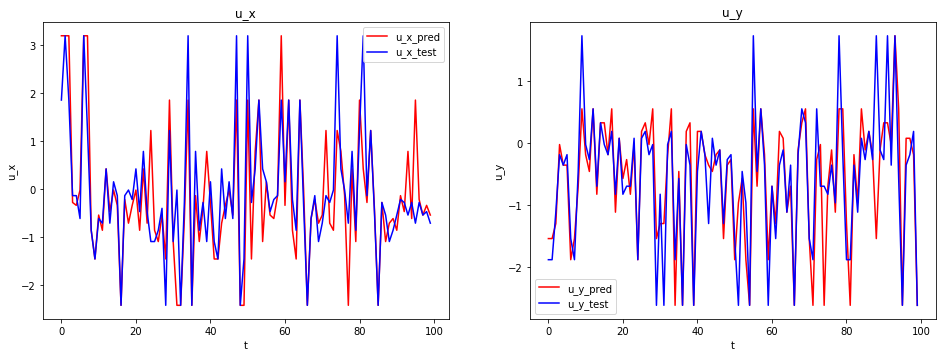

In [85]:
plot_ys(y_pred,y_te)